# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

### <span style='color:#ff5f27'> 📝 Imports

In [36]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [37]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
# os.environ["HOPSWORKS_API_KEY"] = ""
with open('../data/keys/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login(project="ML_Project_Electricity", api_key_value=os.environ["HOPSWORKS_API_KEY"])
fs = project.get_feature_store() 

2025-01-08 14:20:58,660 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-08 14:20:58,702 INFO: Initializing external client
2025-01-08 14:20:58,702 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 14:20:59,809 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207495


In [38]:
# Retrieve feature groups
se3_fg = fs.get_feature_group(
    name='se3_electricity_prices',
    version=1,
)

se4_fg = fs.get_feature_group(
    name='se4_electricity_prices',
    version=1,
)

sthlm_weather_fg = fs.get_feature_group(
    name='stockholm_weather',
    version=1,
)

malmo_weather_fg = fs.get_feature_group(
    name='malmo_weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [42]:
# Select features for training data:
selected_features_se3 = se3_fg.select(["spotpriceeur", "spot_price_rolling", "spot_price_rolling_3h"]).join(sthlm_weather_fg.select_all(), on="time")
selected_features_se3.show(10)

selected_features_se4 = se4_fg.select(["spotpriceeur", "spot_price_rolling", "spot_price_rolling_3h"]).join(malmo_weather_fg.select_all(), on="time")
selected_features_se4.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.15s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.78s) 


,spotpriceeur,spot_price_rolling,spot_price_rolling_3h,date,time,temperature,precipitation,cloud_cover,wind_speed_10m,weekday,month,hour,sunshine_duration
0,78.809998,NaN,109.513331,2023-01-03 00:00:00+00:00,2023-01-03 00:00:00+00:00,5.7,0.0,28,29.9,1,1,0,19403.08
1,164.500000,NaN,167.520004,2023-01-03 00:00:00+00:00,2023-01-03 12:00:00+00:00,5.8,0.0,28,25.3,1,1,12,19403.08
2,69.260002,NaN,72.676666,2023-01-04 00:00:00+00:00,2023-01-04 03:00:00+00:00,5.3,0.6,100,23.5,2,1,3,0.00
3,80.110001,NaN,77.863335,2023-01-04 00:00:00+00:00,2023-01-04 06:00:00+00:00,5.3,0.8,100,28.5,2,1,6,0.00
4,79.720001,NaN,80.773333,2023-01-04 00:00:00+00:00,2023-01-04 13:00:00+00:00,7.9,1.7,100,34.1,2,1,13,0.00
5,57.259998,NaN,62.000000,2023-01-04 00:00:00+00:00,2023-01-04 21:00:00+00:00,8.0,0.1,100,31.6,2,1,21,0.00
6,27.760000,NaN,27.863333,2023-01-05 00:00:00+00:00,2023-01-05 03:00:00+00:00,7.2,0.4,100,32.2,3,1,3,0.00
7,109.910004,NaN,110.233335,2023-01-06 00:00:00+00:00,2023-01-06 12:00:00+00:00,2.5,1.8,100,37.7,4,1,12,7.97
8,119.919998,NaN,137.583333,2023-01-06 00:00:00+00:00,2023-01-06 19:00:00+00:00,5.7,0.0,10,22.3,4,1,19,7.97
9,91.790001,NaN,87.926666,2023-01-07 00:00:00+00:00,2023-01-07 13:00:00+00:00,6.2,1.6,100,19.6,5,1,13,2516.83


In [40]:
# Select features for training data.
# selected_features = air_quality_fg.select(['pm25', 'rolling_mean_pm25']).join(weather_fg.select_all(), on=['city'])
# selected_features_se3.show(-10)

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [44]:
feature_view_se3 = fs.get_or_create_feature_view(
    name='se3_price_fv',
    description="weather features with with hourly electricity price as the target",
    version=1,
    labels=['spotpriceeur'],
    query=selected_features_se3,
)

feature_view_se4 = fs.get_or_create_feature_view(
    name='se4_price_fv',
    description="weather features with with hourly electricity price as the target",
    version=1,
    labels=['spotpriceeur'],
    query=selected_features_se4,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1207495/fs/1195127/fv/se3_price_fv/version/1
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1207495/fs/1195127/fv/se4_price_fv/version/1


## <span style="color:#ff5f27;"> Split the training data into train/test data sets </span>

We use a random split for this

In [45]:
# Split the training data into training and test sets using random split
X_train_se3, X_test_se3, y_train_se3, y_test_se3 = feature_view_se3.train_test_split(test_size=0.2)

X_train_se4, X_test_se4, y_train_se4, y_test_se4 = feature_view_se4.train_test_split(test_size=0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.20s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.66s) 


In [46]:
# Combine the two datasets and create a feature called region
X_train_se3['region'] = 0
X_train_se4['region'] = 1
X_test_se3['region'] = 0
X_test_se4['region'] = 1

X_train = pd.concat([X_train_se3, X_train_se4])
X_test = pd.concat([X_test_se3, X_test_se4])
y_train = pd.concat([y_train_se3, y_train_se4])
y_test = pd.concat([y_test_se3, y_test_se4])

In [47]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)

train_features = X_train.drop(['date', 'time'], axis=1)
test_features = X_test.drop(['date', 'time'], axis=1)


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [48]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [49]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)



MSE: 102.41783650693954
R squared: 0.9536637212865856


In [50]:
df = y_test
df['predicted_price'] = y_pred

In [51]:
df['time'] = X_test['time']
df = df.sort_values(by=['time'])
df.head(10)

,spotpriceeur,predicted_price,time
14277,0.080000,0.473348,2023-01-01 03:00:00+00:00
12086,0.090000,1.637859,2023-01-01 06:00:00+00:00
7727,6.060000,6.080323,2023-01-01 11:00:00+00:00
4385,54.230000,54.777649,2023-01-01 18:00:00+00:00
15424,45.959999,44.888119,2023-01-01 22:00:00+00:00
8844,51.669998,46.497570,2023-01-02 01:00:00+00:00
8844,51.669998,44.982750,2023-01-02 01:00:00+00:00
8845,50.080002,52.129089,2023-01-02 04:00:00+00:00
14278,147.050003,149.009949,2023-01-02 09:00:00+00:00
4387,144.380005,142.794006,2023-01-02 12:00:00+00:00


In [ ]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "price_prediction_models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

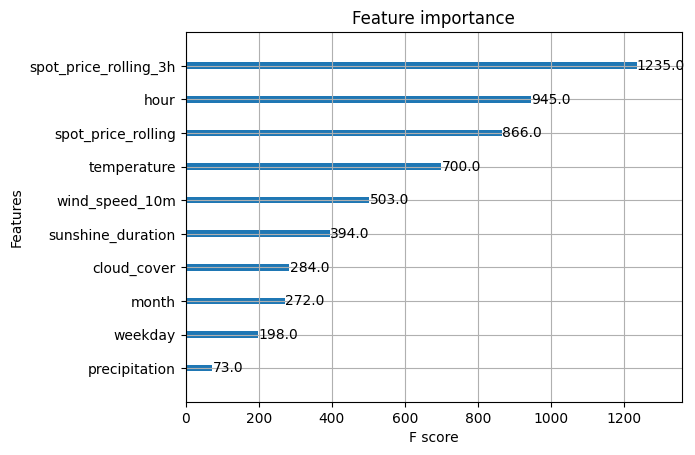

In [52]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=10)
# feature_importance_path = images_dir + "/feature_importance.png"
# plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [57]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [58]:
# Saving the XGBoost regressor object as a json file in the model directory
model_dir = "price_prediction_models"
xgb_regressor.save_model("price_prediction_models/model.json")

In [59]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [60]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'se3_price_xgboost_model'

model = mr.python.create_model(
    name="electricity_price_xgboost_model_with_lagged", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Electricity price prediction model using XGBoost regressor",
)

# Saving the model artifacts to the 'se3_model' directory in the model registry
model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/614033 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/623940 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/611996 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/20029 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/143 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1130 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1207495/models/electricity_price_xgboost_model_with_lagged/1


Model(name: 'electricity_price_xgboost_model_with_lagged', version: 1)